In [50]:
import cv2
from cv2 import VideoCapture
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm
from typing import *

# Convert video to image frames

In [51]:
def video2frames(vid_path: str, save_path: str) -> None:
    """Convert videos to frame and save frames.

    Args:
        vid_path: path to video
        save_path: path to save frames to
    """
    assert save_path[-1] == "/", f"Requires a directory, {save_path} must end in '/'"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    vidcap = VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0
    while success:
        # save frame as JPEG file
        cv2.imwrite(save_path + f"{count}.jpg", image)
        success, image = vidcap.read()
        count += 1
    print(f"Saved {count} frames to {save_path}.")
    vidcap.release()

In [52]:
vid_paths = [
    # "./data/Records/bfmc2020_online_1.avi",
    "./data/Records/bfmc2020_online_2.avi",
    # "./data/Records/bfmc2020_online_3.avi",
    # "./data/Records/home.mp4",
]
path = f"./data/bfmc2020/frames_3/"

# video2frames(vid_paths, path)

## Import converted image frames

In [53]:
def import_images(path: str) -> List[np.ndarray]:
    """Import all the images of a given directory path and return an array of images

    Args:
        path:(str) path to dir (Make sure path ends in a /)

    Returns:List[np.ndarray] List of images.

    """
    assert path[-1] == "/", f"Requires a directory, {path} must end in a '/'"

    # get file names of frames
    col_frames = os.listdir(path)
    col_frames.sort(key=lambda f: int(re.sub("\D", "", f)))

    # load frames
    col_images = []
    for i in tqdm(col_frames):
        img = cv2.imread(path + i)
        col_images.append(img)
    return col_images


path = "./data/bfmc2020/frames_3/"
col_images = import_images(path)
len(col_images)

100%|██████████| 2163/2163 [01:13<00:00, 29.62it/s]


2163

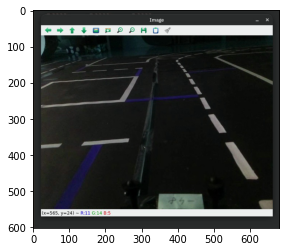

In [54]:
plt.imshow(col_images[200])

## Intersection Detection

(True, <matplotlib.image.AxesImage at 0x7fd9fc86a100>)

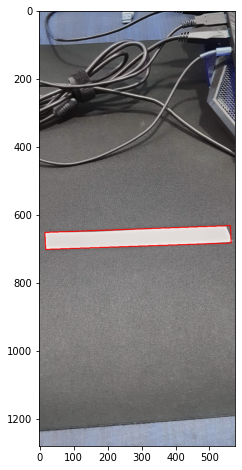

In [38]:
def det_intersection(img:np.ndarray, area_threshold:float = 20_000):
    """Detect Intersection line in the image
    
    Args:
        img: input image
        area_threshold: request area threshold for detection
    
    Returns:
        detected:(bool) if intersection line is detected
        out_img:(np.ndaarray) image with box around intersection line
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray,
                           (15, 15), 6)
    ret, thresh = cv2.threshold(blurred,
                            180, 255,
                            cv2.THRESH_BINARY)

    contours, hier = cv2.findContours(thresh.copy(),
                                  cv2.RETR_TREE,
                                  cv2.CHAIN_APPROX_SIMPLE)
    out_img = img.copy()
    detected = False

    for c in contours:
        area = cv2.contourArea(c)
        if area > area_threshold:
            detected = True
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            # convert all coordinates floating point values to int
            box = np.int0(box)
            # draw a red 'nghien' rectangle
            cv2.drawContours(out_img, [box], 0, (255, 0, 0), 2)
    return detected, out_img


### Intersection detection on images

In [ ]:
path = "./data/intersection_det.jpeg"
img = cv2.imread(path)
_,ax = plt.subplots(figsize=(10,8))
det, out_img = det_intersection(img)
det, ax.imshow(out_img)

### Intersection detection of video

In [43]:
def process_video(video_path: str, out_path: str):
    cap = cv2.VideoCapture(video_path)
    out = None
    count = 0
    while cap.isOpened():
        # try:
        ret, frame = cap.read()
        image = frame
        if out == None:
            h, w, _ = image.shape
            out = cv2.VideoWriter(
                out_path, cv2.VideoWriter_fourcc(*"DIVX"), 15, (w, h)
            )

        if not ret or cv2.waitKey(1) == 27:
            break
        
        _, out_img = det_intersection(image)

        out.write(out_img)
        count += 1
    print(f"No. of frames : {count}")
    cap.release()
    cv2.destroyAllWindows()

In [44]:
process_video("./data/Records/bfmc2020_online_2.avi", f"./data/intersection_det.avi")

No. of frames : 2002
